In [133]:
#Modul Utama
import pandas as pd
import numpy as np

#Modul Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt


#Modul untuk imputer
from sklearn.impute import SimpleImputer, KNNImputer


#Modul Preprocesiing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce


#Modul split tuning parameter, & cross validasi
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,GridSearchCV, RandomizedSearchCV

#Modul Machine Learning
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import pickle

#modul metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error

#Modul Feature Selection
from sklearn.feature_selection import SelectPercentile, SelectKBest,f_regression, f_classif

#Modul untuk Pipeline
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline


#Modul untuk handling imbalance method
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

#Modul untuk running time
import time

pd.set_option('display.max_columns', None)

# Import Data

In [93]:
# read dataset
df = pd.read_csv('toyota.csv')
df['Doors']=np.where(df['Doors']=='three',3,
                    np.where(df['Doors']=='four',4,
                    np.where(df['Doors']=='five',5,df['Doors'])))
df['Doors']=df['Doors'].astype(int)

df['HP']=np.where(df['HP']=='????','97',df['HP'])
df['HP']=df['HP'].astype(int)

df['KM']=np.where(df['KM']=='??','81106',df['KM'])
df['KM']=df['KM'].astype(int)

# Define Feature & Label

In [94]:
#feature
X=df[[ 'Age', 'KM', 'FuelType', 'HP', 'MetColor',
       'Automatic', 'CC', 'Doors', 'Weight']]

y=df['Price']

## Splitting Data I

In [95]:
from sklearn.model_selection import train_test_split
## split data?
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=10)


# Descriptive Statistic

In [96]:
X_train.select_dtypes(include='object').describe()

,FuelType
count,935
unique,3
top,Petrol
freq,823


In [97]:
X_train.describe()

,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight
count,938.00,1005.00,1005.00,905.00,1005.00,1005.00,1005.00,1005.00
mean,55.76,68919.90,101.77,0.68,0.06,1567.44,4.02,1072.01
std,18.41,37075.67,14.92,0.47,0.24,184.30,0.95,51.32
min,1.00,1.00,69.00,0.00,0.00,1300.00,2.00,1000.00
25%,44.00,43632.00,90.00,0.00,0.00,1400.00,3.00,1040.00
50%,60.00,63635.00,110.00,1.00,0.00,1600.00,4.00,1070.00
75%,69.00,88000.00,110.00,1.00,0.00,1600.00,5.00,1085.00
max,80.00,243000.00,192.00,1.00,1.00,2000.00,5.00,1615.00


## Normality Test for Numerical

In [98]:
from scipy.stats import normaltest

# Apply normaltest to each column and collect the p-values
normality_results = X_train.select_dtypes(include='number').apply(lambda col: normaltest(col.dropna())[1]).reset_index()

# Rename columns
normality_results.columns = ['Column', 'p-value']

# Print the result
normality_results

,Column,p-value
0,Age,0.00
1,KM,0.00
2,HP,0.00
3,MetColor,0.00
4,Automatic,0.00
5,CC,0.00
6,Doors,0.00
7,Weight,0.00


In [99]:
normality_results[normality_results['p-value']<=0.05]['Column'].unique()

# normality_results[normality_results['p-value']>0.05]['Column'].unique()

array(['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors',
       'Weight'], dtype=object)

## Multicolinearity

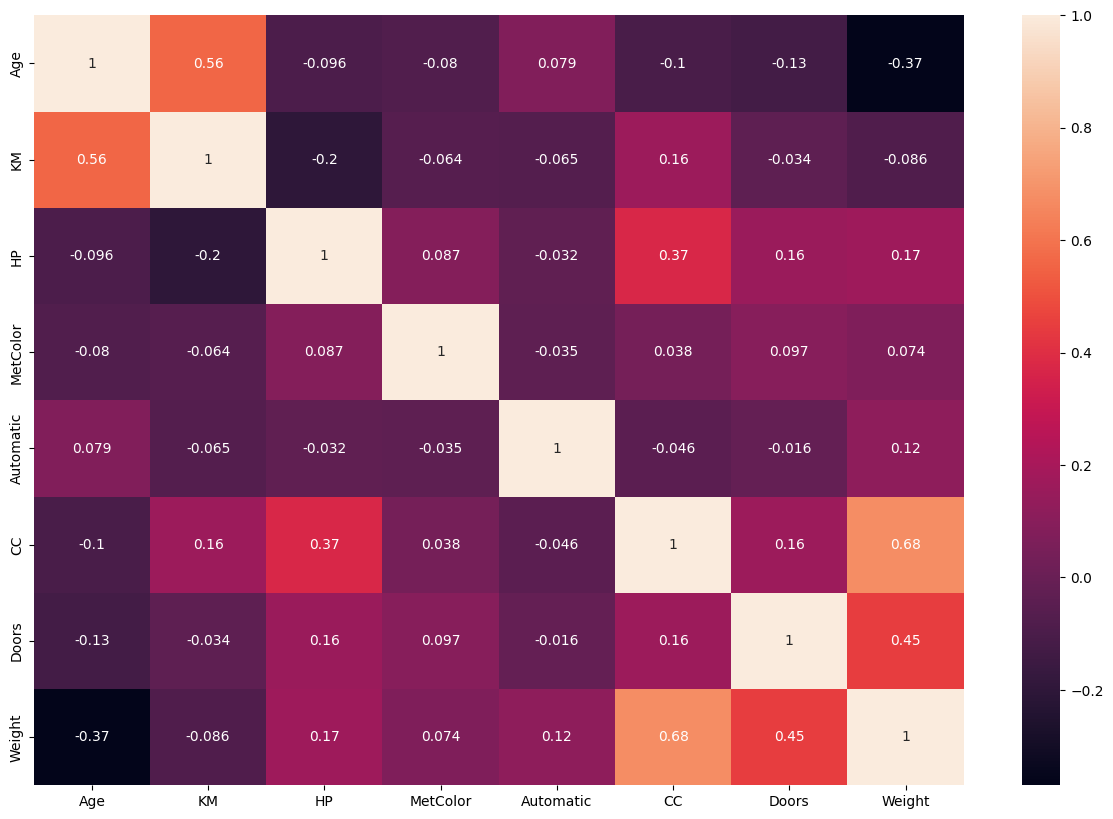

In [100]:
plt.figure(figsize=(15,10))
sns.heatmap(X_train.select_dtypes(include='number').corr(method='spearman'),annot=True)
plt.show()

In [101]:
dfcorr=X_train.select_dtypes(include='number')
corrMatrix=dfcorr.corr(method='spearman')
already_in = set()
result = []
for col in corrMatrix:
    large_corr = corrMatrix[col][corrMatrix[col] >= 0.7 ].index.tolist()
    if large_corr and col not in already_in:
        already_in.update(set(large_corr))
        large_corr.append(col)
        result.append(large_corr)

result



[['Age', 'Age'],
 ['KM', 'KM'],
 ['HP', 'HP'],
 ['MetColor', 'MetColor'],
 ['Automatic', 'Automatic'],
 ['CC', 'CC'],
 ['Doors', 'Doors'],
 ['Weight', 'Weight']]

In [102]:
# list(pd.DataFrame(result)[2].unique())+list(pd.DataFrame(result)[3].unique())
# +list(pd.DataFrame(result)[4].unique())

## Selection : Feature Importance

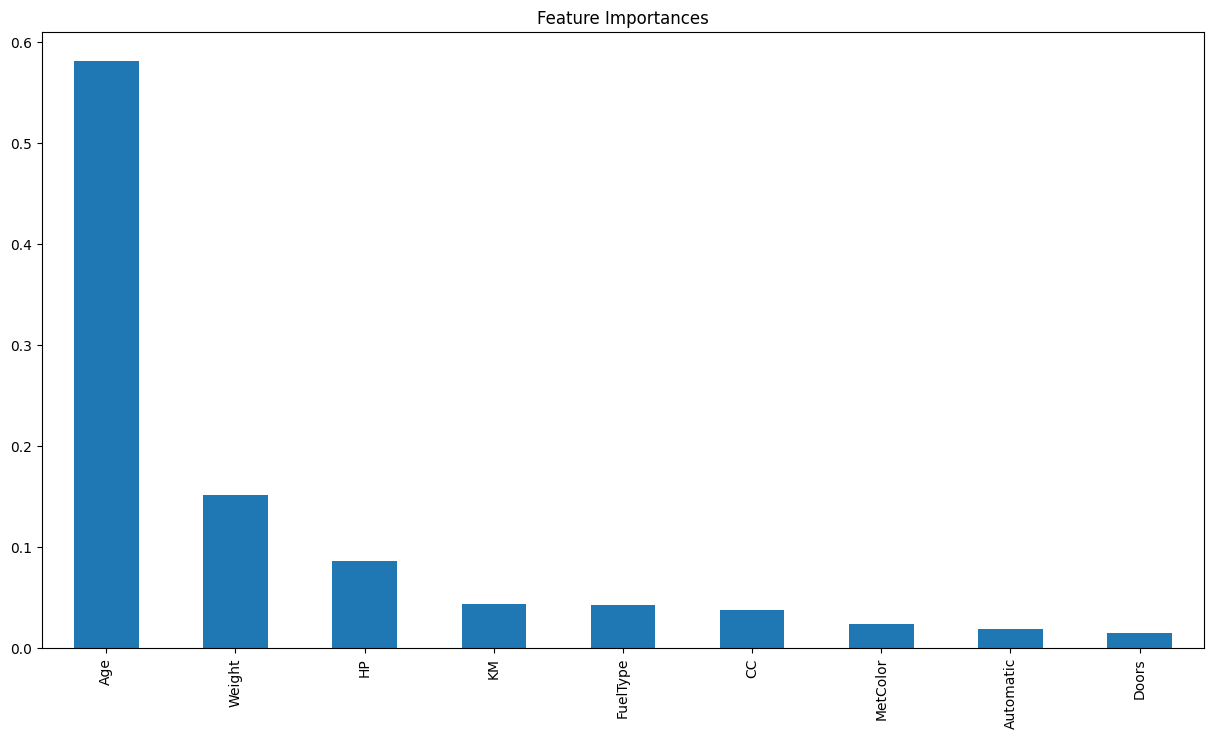

In [103]:
X_train_feat=X_train.copy()
categorical = X_train_feat.select_dtypes(include = "object").columns
X_train_feat[categorical] = X_train_feat[categorical].fillna(value='missing')
le = LabelEncoder()
X_train_feat[categorical] = X_train_feat[categorical].astype('string').apply(le.fit_transform)

xgb=XGBRegressor()
xgb.fit(X_train_feat,y_train)
xgb_coef1 = pd.Series(xgb.feature_importances_, X_train_feat.columns).sort_values(ascending = False)
plt.figure(figsize=(15,8))
xgb_coef1.iloc[:50].plot(kind='bar', title='Feature Importances')
plt.show()

In [104]:
feat_imp=pd.DataFrame(xgb_coef1)
feat_imp[feat_imp[0]>0.01]

,0
Age,0.58
Weight,0.15
HP,0.09
KM,0.04
FuelType,0.04
CC,0.04
MetColor,0.02
Automatic,0.02
Doors,0.01


In [105]:
feat_imp[feat_imp[0]>0.01].reset_index()['index'].unique()

array(['Age', 'Weight', 'HP', 'KM', 'FuelType', 'CC', 'MetColor',
       'Automatic', 'Doors'], dtype=object)

In [106]:
cols=['FuelType']
for i in cols:
    print(i)
    print(pd.concat([X_train,y_train],axis=1).groupby(i)['Price'].mean().reset_index().sort_values(by='Price')[i].unique())
    display(pd.concat([X_train,y_train],axis=1).groupby(i)['Price'].mean().reset_index().sort_values(by='Price'))

FuelType
['CNG' 'Petrol' 'Diesel']


,FuelType,Price
0,CNG,9255.00
2,Petrol,10695.02
1,Diesel,11008.21


## Final Feature

In [107]:
fitur=['Age', 'CC', 'Weight', 'HP',
       'FuelType', 
       'KM', 'Automatic',
       'Doors', 'MetColor']

X_train=X_train[fitur]
X_test=X_test[fitur]

## Pipeline

In [108]:
# Pipeline untuk preprocessing numerik dan kategorik


# Urutan kategori yang diinginkan
categories1 = [['CNG', 'Petrol', 'Diesel']]


preprocessor = ColumnTransformer(
    transformers=[
        ('Numerical 1', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler())
        ]), ['Age', 'CC', 'Weight', 'HP',  'KM', 'Automatic', 'Doors']),

        ('Numerical 2', Pipeline([
            ('imputer', SimpleImputer(strategy='constant',fill_value=1)),
            ('scaler', StandardScaler())
        ]), [ 'MetColor'])
        ,

        ('Categorical 2', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(categories=categories1))
        ]), ['FuelType'])
    ]
)


# Definisikan pipeline tanpa classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('regressor', RandomForestRegressor())  # Placeholder untuk classifier
])



param_grid = [
    {
        'feature_selection__k': [5,15],  # Ubah nilai k dari 1 hingga 20
        'regressor': [MLPRegressor()],
        'regressor__learning_rate': ['constant'],
        'regressor__learning_rate_init': [0.01, 0.1],
        'regressor__alpha': [0.0001,1, 10],
        'regressor__solver': ['lbfgs', 'adam']
    },
    
        {
        'feature_selection__k': [5,15],  # Ubah nilai k dari 1 hingga 20
        'regressor': [CatBoostRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20]
    },
        {
        'feature_selection__k': [5,15],  # Ubah nilai k dari 1 hingga 20
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1,  4]
    },
    {
        'feature_selection__k': [5,15],  # Ubah nilai k dari 1 hingga 20
        'regressor': [DecisionTreeRegressor()],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1,  4]
    },
    {
        'feature_selection__k': [5,15],  # Ubah nilai k dari 1 hingga 20
        'regressor': [LinearRegression()]
    },
    {
        'feature_selection__k': [5,15],  # Ubah nilai k dari 1 hingga 20
        'regressor': [XGBRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__subsample': [0.6, 0.8]
    },
    {
        'feature_selection__k': [5,15],  # Ubah nilai k dari 1 hingga 20
        'regressor': [svm.SVC()],
        'regressor__kernel': ['linear', 'poly'],
        'regressor__C': [1,5]
    }
]

# Buat GridSearchCV dengan pipeline
gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

# Measure the fitting time
start_time = time.time()


# Fit GridSearchCV ke data
gscv.fit(X_train, y_train)


end_time = time.time()

fitting_time = end_time - start_time
print(f"Fitting time: {fitting_time:.2f} seconds")


/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs faile

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/sta

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/neura

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

Learning rate set to 0.451801
0:	learn: 2712.1255663	total: 58.3ms	remaining: 2.86s
1:	learn: 2128.0287709	total: 58.8ms	remaining: 1.41s
2:	learn: 1791.5032552	total: 59.2ms	remaining: 928ms
3:	learn: 1607.3634840	total: 59.7ms	remaining: 686ms
4:	learn: 1479.9025693	total: 60ms	remaining: 540ms
5:	learn: 1391.2705549	total: 60.3ms	remaining: 442ms
6:	learn: 1331.1400268	total: 60.7ms	remaining: 373ms
7:	learn: 1289.2801612	total: 61ms	remaining: 320ms
8:	learn: 1247.6257406	total: 61.3ms	remaining: 279ms
9:	learn: 1222.9216639	total: 61.6ms	remaining: 246ms
10:	learn: 1199.2941198	total: 61.9ms	remaining: 219ms
11:	learn: 1178.0652229	total: 62.2ms	remaining: 197ms
12:	learn: 1161.9757140	total: 62.5ms	remaining: 178ms
13:	learn: 1138.3203185	total: 62.9ms	remaining: 162ms
14:	learn: 1130.8313742	total: 63.2ms	remaining: 147ms
15:	learn: 1114.6701238	total: 63.5ms	remaining: 135ms
16:	learn: 1104.7094875	total: 63.8ms	remaining: 124ms
17:	learn: 1096.9291514	total: 64.1ms	remaining: 

0:	learn: 2481.6349579	total: 1.14ms	remaining: 55.9ms
1:	learn: 1922.9613071	total: 1.76ms	remaining: 42.2ms
2:	learn: 1615.6095337	total: 2.3ms	remaining: 36.1ms
3:	learn: 1458.4617249	total: 2.69ms	remaining: 31ms
4:	learn: 1382.4199807	total: 3.07ms	remaining: 27.6ms
5:	learn: 1285.9345430	total: 3.45ms	remaining: 25.3ms
6:	learn: 1240.7607661	total: 3.79ms	remaining: 23.3ms
7:	learn: 1204.4693343	total: 4.16ms	remaining: 21.8ms
8:	learn: 1180.2366326	total: 4.54ms	remaining: 20.7ms
9:	learn: 1161.5362191	total: 4.92ms	remaining: 19.7ms
10:	learn: 1139.4256985	total: 5.29ms	remaining: 18.8ms
11:	learn: 1126.0564053	total: 5.66ms	remaining: 17.9ms
12:	learn: 1088.3540310	total: 6.04ms	remaining: 17.2ms
13:	learn: 1076.9940952	total: 6.4ms	remaining: 16.5ms
14:	learn: 1069.3605661	total: 7.38ms	remaining: 17.2ms
15:	learn: 1056.9358311	total: 8.3ms	remaining: 17.6ms
16:	learn: 1033.3745037	total: 9.13ms	remaining: 17.7ms
17:	learn: 1018.3473089	total: 9.51ms	remaining: 16.9ms
18:	lea

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=11. All the features will be returned.
  warnings.warn(
/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is 

Fitting time: 27.40 seconds



30 fits failed out of a total of 1100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andyhermawan/anaconda3/lib/python3.11/site-packages/imblearn/pipeline.py", line 326, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/Users/and

In [109]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical 1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['Age', 'CC', 'Weight', 'HP',
                                                   'KM', 'Automatic',
                                                   'Doors']),
                                                 ('Numerical 2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MetColor']),
                                                 ('Categorical...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [110]:
# Extract the SelectKBest step
select_k_best = gscv.best_estimator_.named_steps['feature_selection']

# Extract the column transformer step
column_transformer = gscv.best_estimator_.named_steps['preprocessor']

# Get the feature names after one-hot encoding
num1_feature_names= column_transformer.named_transformers_['Numerical 1'].get_feature_names_out(['Age', 'CC', 'Weight', 'HP',  'KM', 'Automatic', 'Doors'])
num2_feature_names= column_transformer.named_transformers_['Numerical 2'].get_feature_names_out([ 'MetColor'])

ohe_feature_names= column_transformer.named_transformers_['Categorical 2'].get_feature_names_out(['FuelType'])

feat_cols=list(num1_feature_names)+list(num2_feature_names)+list(ohe_feature_names)
# +list(ord1_feature_names)+list(ord2_feature_names)

# select_k_best.get_feature_names_out(feat_cols)

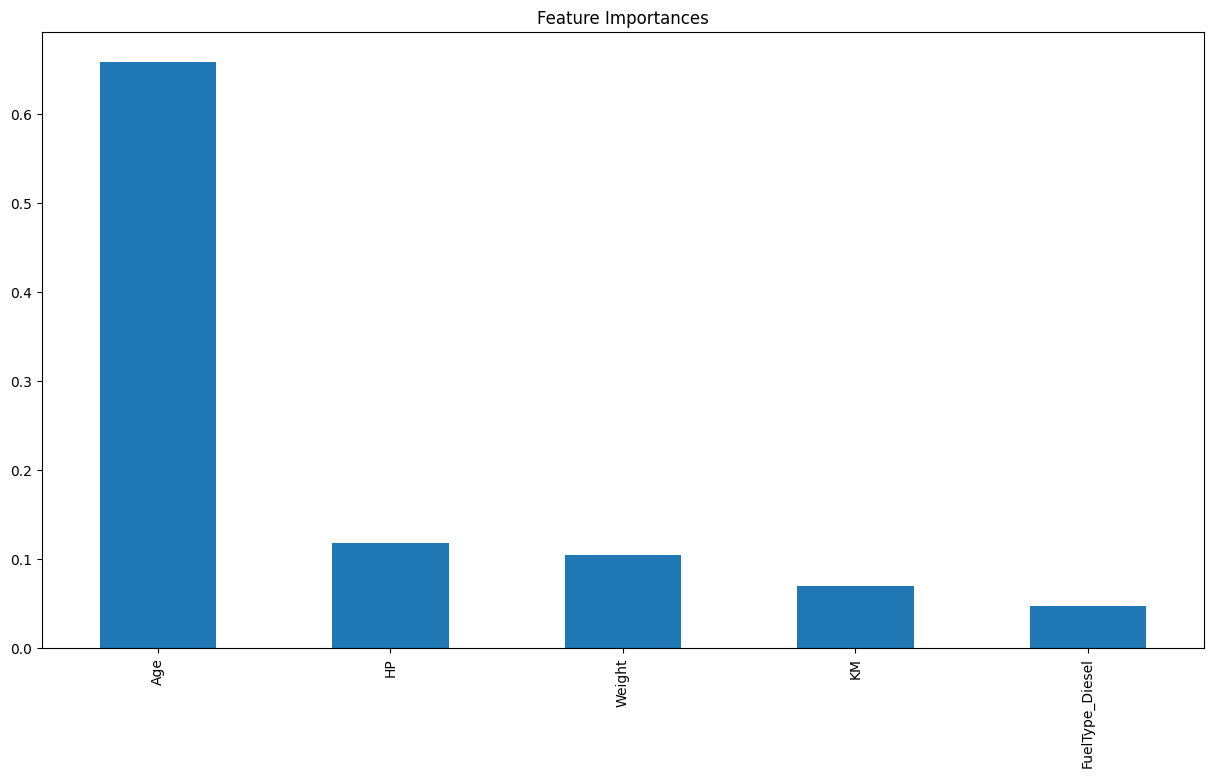

In [111]:
# Get feature importance from the best model
best_model = gscv.best_estimator_.named_steps['regressor']


feature_names = gscv.best_estimator_.named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = np.array(feat_cols)[feature_names]


model_coef1 = pd.Series(best_model.feature_importances_, selected_feature_names).sort_values(ascending = False)
plt.figure(figsize=(15,8))
model_coef1.iloc[:50].plot(kind='bar', title='Feature Importances')
plt.show()

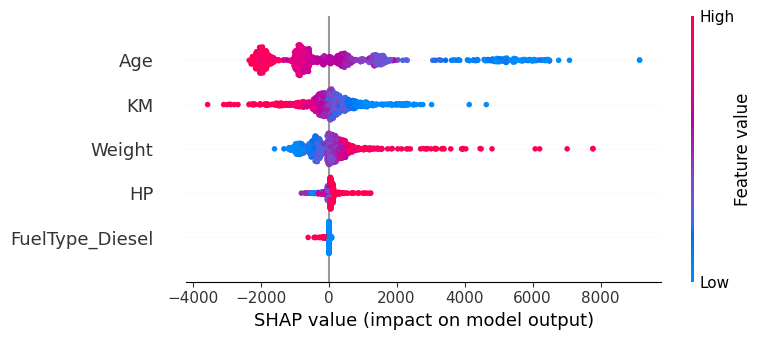

In [112]:
import shap

# Apply preprocessing to the training data
X_train_preprocessed = gscv.best_estimator_.named_steps['preprocessor'].transform(X_train)

# Apply feature selection to the preprocessed data
X_train_selected = gscv.best_estimator_.named_steps['feature_selection'].transform(X_train_preprocessed)

# Get the feature names after selection
feature_names = gscv.best_estimator_.named_steps['feature_selection'].get_support(indices=True)
selected_feature_names = np.array(feat_cols)[feature_names]

# Get feature importance from the best model
best_model = gscv.best_estimator_.named_steps['regressor']


# Generate SHAP values
explainer = shap.Explainer(best_model, X_train_selected)
shap_values = explainer(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, feature_names=selected_feature_names)

In [114]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__k,param_regressor,param_regressor__alpha,param_regressor__learning_rate,param_regressor__learning_rate_init,param_regressor__solver,param_regressor__max_depth,param_regressor__n_estimators,param_regressor__min_samples_leaf,param_regressor__min_samples_split,param_regressor__subsample,param_regressor__C,param_regressor__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.36,0.06,0.02,0.01,5,MLPRegressor(),0.00,constant,0.01,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-960.62,-1008.64,-920.45,-960.64,-1041.69,-978.41,42.21,108
1,0.45,0.03,0.01,0.00,5,MLPRegressor(),0.00,constant,0.01,adam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-2115.01,-1951.26,-1898.38,-1871.01,-1841.50,-1935.43,96.79,213
2,0.40,0.03,0.00,0.00,5,MLPRegressor(),0.00,constant,0.10,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-1002.52,-979.42,-970.82,-978.03,-1042.86,-994.73,26.31,124
3,0.19,0.08,0.00,0.00,5,MLPRegressor(),0.00,constant,0.10,adam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-963.54,-973.49,-975.53,-994.49,-1017.83,-984.98,19.24,115
4,0.25,0.02,0.00,0.00,5,MLPRegressor(),1,constant,0.01,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-987.91,-967.62,-949.91,-981.58,-1014.51,-980.31,21.51,111
5,0.27,0.02,0.00,0.00,5,MLPRegressor(),1,constant,0.01,adam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-2015.91,-2107.45,-1917.68,-1949.57,-1846.81,-1967.49,88.66,214
6,0.21,0.02,0.00,0.00,5,MLPRegressor(),1,constant,0.10,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-1012.87,-965.72,-952.12,-929.24,-1024.96,-976.98,36.37,105
7,0.15,0.02,0.00,0.00,5,MLPRegressor(),1,constant,0.10,adam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-1019.66,-978.94,-992.27,-957.95,-996.97,-989.16,20.39,121
8,0.26,0.06,0.00,0.00,5,MLPRegressor(),10,constant,0.01,lbfgs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-982.92,-945.14,-947.60,-920.48,-1098.67,-978.96,63.07,109
9,0.25,0.02,0.01,0.00,5,MLPRegressor(),10,constant,0.01,adam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'feature_selection__k': 5, 'regressor': MLPRe...",-2148.98,-1877.42,-1891.04,-1914.61,-1827.03,-1931.82,112.30,212


In [115]:
y_pred=gscv.best_estimator_.predict(X_test)


In [116]:
print('MSE',mean_squared_error(y_test, y_pred))
print('MAE',mean_absolute_error(y_test, y_pred))
print('RMSE',mean_squared_error(y_test, y_pred)**(0.5))


MSE 1570296.6684771094
MAE 878.3468586861949
RMSE 1253.1147866325373


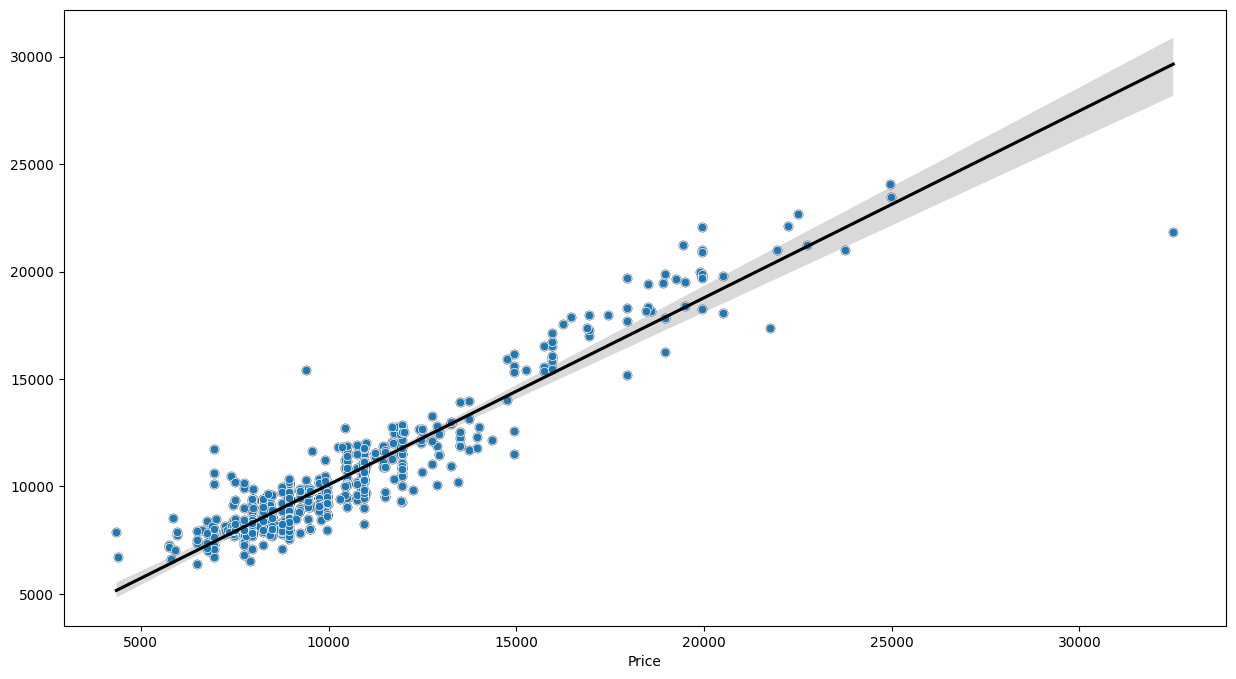

In [117]:
plt.figure(figsize=(15,8))
sns.regplot(x=y_test,y=y_pred,color='black')
sns.scatterplot(x=y_test,y=y_pred)
plt.show()

## Handle Prize Outlier

In [118]:
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)
X_train_out=X_train.drop([ 110, 111],axis=0)
X_test_out=X_test.drop([ 109],axis=0)
y_train_out=y_train[y_train['Price']<30000]
y_test_out=y_test[y_test['Price']<30000]

model=gscv.best_estimator_
model.fit(X_train_out,y_train_out)

y_pred=model.predict(X_test_out)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [119]:
print('MSE',mean_squared_error(y_test_out, y_pred))
print('MAE',mean_absolute_error(y_test_out, y_pred))
print('RMSE',mean_squared_error(y_test_out, y_pred)**(0.5))


MSE 1314332.7306475306
MAE 872.0457826126453
RMSE 1146.443513936701


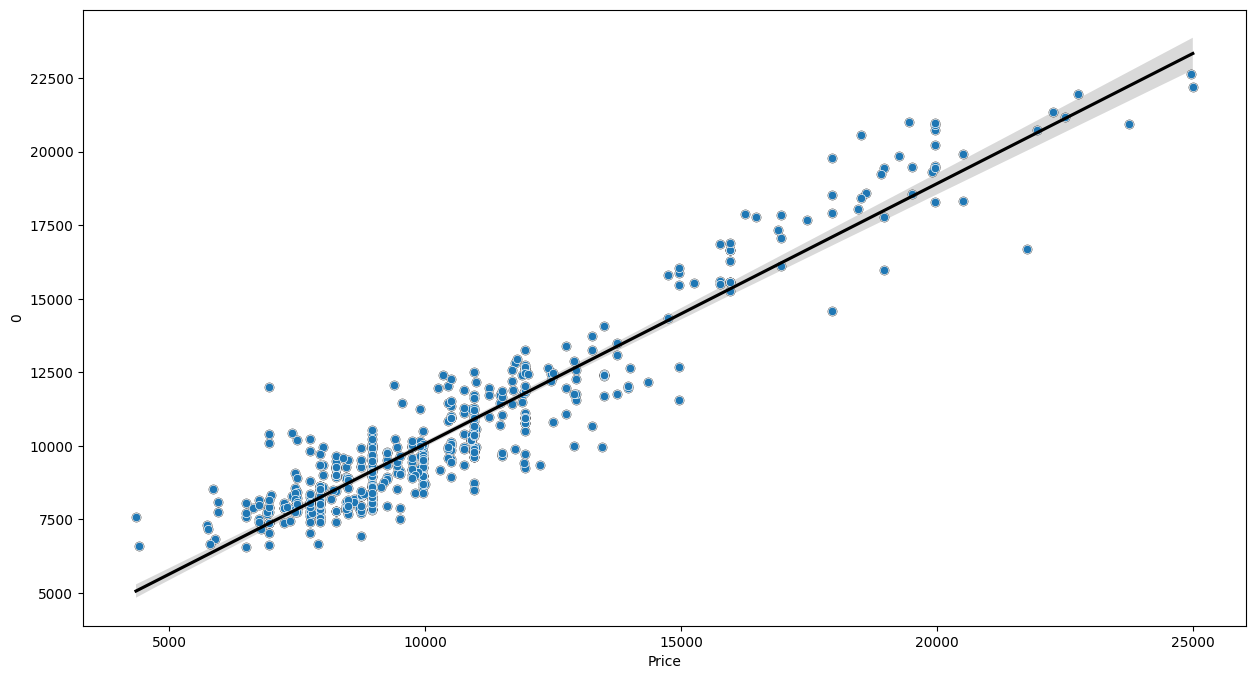

In [120]:
y_test_out=y_test_out.reset_index(drop=True)
y_pred=pd.DataFrame(y_pred)
df_gab=pd.concat([y_test_out,y_pred],axis=1)
plt.figure(figsize=(15,8))
sns.regplot(x=y_test_out,y=y_pred,color='black')
sns.scatterplot(x='Price',y=0,data=df_gab)
plt.show()

## Rule Based 

In [121]:
df['Age']=round(df['Age'].fillna(df['Age'].mean()))
df['FuelType']=df['FuelType'].fillna(df['FuelType'].mode()[0])


df['bin_age']=pd.qcut(df['Age'],4,labels=['Sangat Muda', 'Muda', 'Tua',' Sangat Tua'])
df['bin_KM']=pd.qcut(df['KM'],3,labels=['KM Rendah', 'KM Sedang', 'KM Tinggi'])
df['bin_CC']=pd.qcut(df['CC'],2,labels=['CC Rendah',  'CC Tinggi'])
df['bin_HP']=pd.qcut(df['HP'],2,labels=['HP Rendah',  'HP Tinggi'])

df1=df.groupby(['bin_age','bin_KM','bin_CC','bin_HP','FuelType','Automatic'])['Price'].mean().reset_index()
df1.columns=['bin_age','bin_KM','bin_CC','bin_HP','FuelType','Automatic','flag_RB']
df1

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,bin_age,bin_KM,bin_CC,bin_HP,FuelType,Automatic,flag_RB
0,Sangat Muda,KM Rendah,CC Rendah,HP Rendah,CNG,0,12950.00
1,Sangat Muda,KM Rendah,CC Rendah,HP Rendah,CNG,1,NaN
2,Sangat Muda,KM Rendah,CC Rendah,HP Rendah,Diesel,0,NaN
3,Sangat Muda,KM Rendah,CC Rendah,HP Rendah,Diesel,1,NaN
4,Sangat Muda,KM Rendah,CC Rendah,HP Rendah,Petrol,0,15210.47
5,Sangat Muda,KM Rendah,CC Rendah,HP Rendah,Petrol,1,16821.07
6,Sangat Muda,KM Rendah,CC Rendah,HP Tinggi,CNG,0,NaN
7,Sangat Muda,KM Rendah,CC Rendah,HP Tinggi,CNG,1,NaN
8,Sangat Muda,KM Rendah,CC Rendah,HP Tinggi,Diesel,0,NaN
9,Sangat Muda,KM Rendah,CC Rendah,HP Tinggi,Diesel,1,NaN


In [122]:
df2=pd.merge(df,df1, how='left',on=['bin_age','bin_KM','bin_CC','bin_HP','FuelType','Automatic'])
df2.head()

,Unnamed: 0,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight,bin_age,bin_KM,bin_CC,bin_HP,flag_RB
0,0,13500,23.00,46986,Diesel,90,1.00,0,2000,3,1165,Sangat Muda,KM Rendah,CC Tinggi,HP Rendah,17003.64
1,1,13750,23.00,72937,Diesel,90,1.00,0,2000,3,1165,Sangat Muda,KM Sedang,CC Tinggi,HP Rendah,15200.00
2,2,13950,24.00,41711,Diesel,90,NaN,0,2000,3,1165,Sangat Muda,KM Rendah,CC Tinggi,HP Rendah,17003.64
3,3,14950,26.00,48000,Diesel,90,0.00,0,2000,3,1165,Sangat Muda,KM Rendah,CC Tinggi,HP Rendah,17003.64
4,4,13750,30.00,38500,Diesel,90,0.00,0,2000,3,1170,Sangat Muda,KM Rendah,CC Tinggi,HP Rendah,17003.64


## Splitting Data II

In [123]:
#feature
X=df2[[ 'Age', 'KM', 'FuelType', 'HP', 'MetColor',
       'Automatic', 'CC', 'Doors', 'Weight','flag_RB']]

y=df2['Price']
X_train2, X_test2, y_train2, y_test2=train_test_split(X,y,test_size=0.3,random_state=10)


In [124]:
y_pred=X_test2['flag_RB']

In [125]:
print('MSE',mean_squared_error(y_test2, y_pred))
print('MAE',mean_absolute_error(y_test2, y_pred))
print('RMSE',mean_squared_error(y_test2, y_pred)**(0.5))


MSE 3808027.872368163
MAE 1353.486993741572
RMSE 1951.4168884090768


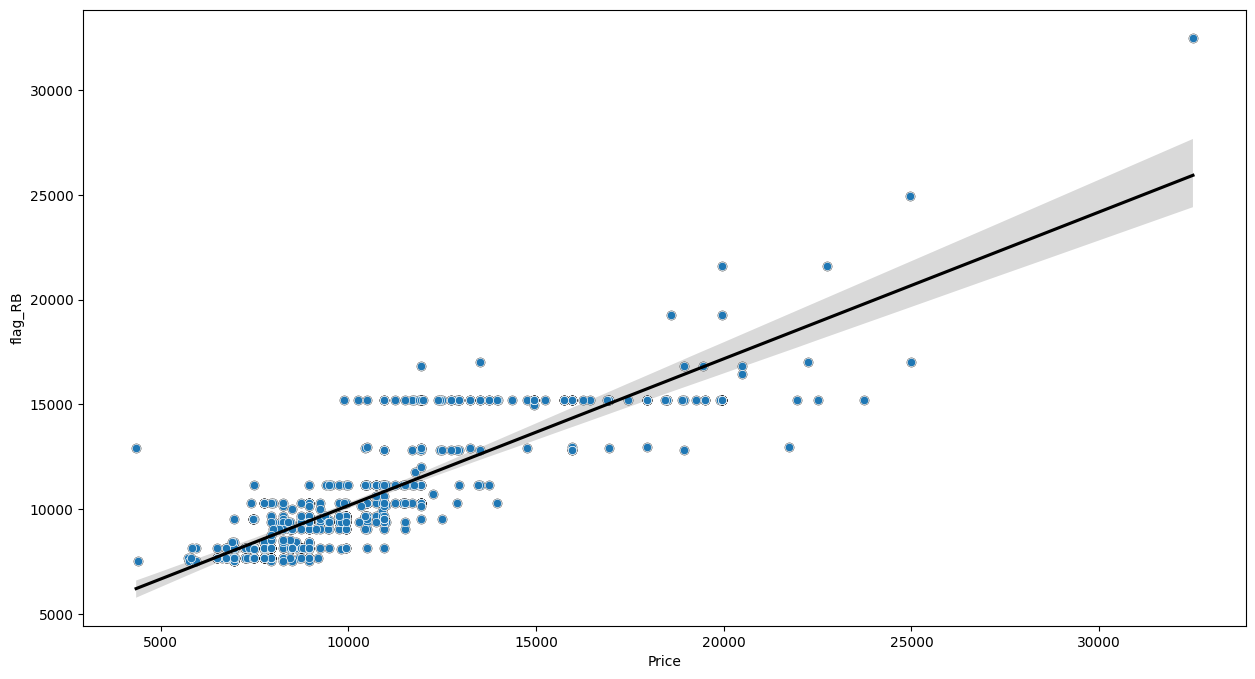

In [128]:
plt.figure(figsize=(15,8))
sns.regplot(x=y_test,y=y_pred,color='black')
sns.scatterplot(x=y_test2,y=y_pred)
plt.show()

## ML vs Rule Based

**`Rule Based`** :
Pada penggunaan rule based, model menghasilkan MAE sebesar `1300` Dollar, artinya setiap prediksi yang dilakukan oleh model, punya kecendrungan meleset sebesar `1300` Dollar. Anggaplah terdapat 100 mobil yang telah dijual, artinya kerugian yang dihasilkan jika menggunakan rulebased sebesar `100 x 1300 = 130000` Dollar.


**`Machine Learning`** :
Sedangkan jika menggunakan Machine Learning, model menghasilkan MAE sebesar `872` Dollar, artinya setiap prediksi yang dilakukan oleh model, punya kecendrungan meleset sebesar `872` Dollar. Jika dianggap terdapat 100 mobil yang telah dijual, artinya kerugian yang dihasilkan jika menggunakan machine learning sebesar `100 x 872 = 87200` Dollar.

Dengan menggunakan ML, bisa menekan kerugian sebesar 37% dibandingkan menggunakan Rulebased.


# Save Model

In [135]:
# Model Pickling
gscv.best_estimator_.fit(X,y) # FINAL MODEL
filename = 'Model Final.sav'
pickle.dump(gscv.best_estimator_,open(filename,'wb'))

# Limitasi Model

Model perlu dibatasi pada nilai-nilai fitur numerik berikut ini


| Fitur | Min | Max | 
| -- | -- | -- | 
| Age | 0 | 20 |
| Weight | 2021-02 | 400 | 
| HP |  | ... | 
| KM | 2021-12 | 50 | 

dan juga kategorik sebagai berikut
| Fitur | Unique Value |  
| -- | -- | 
| FuelType | CNG, Diesel, Petrol | 